<a href="https://colab.research.google.com/github/Charlotte-99/Classifying_Cosmological_Data/blob/main/CMBMiniMapGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating maps using Healpy

In [ ]:
!pip install healpy

In [ ]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from matplotlib.colors import ListedColormap

Saving data to Google Drive directly

In [ ]:
# Mount google drive folder with .fits maps
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to project folder
import os
os.chdir('/content/drive/My Drive/Project')

# **Importing Planck Maps**

We can download the data from the official Planck map using https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/ as our resource. This notebook section relies heavily on https://zonca.dev/2020/09/planck-spectra-healpy.html to format the data.

Here, after editing out the # at the beginning of the .txt file, we import the power spectrum. We also import a .txt file to generate a colourmap similar to what official Planck maps use.

(Alternatively, could use data files from CAMB).

In [ ]:
uploaded = files.upload()

Saving planck_spectrum.txt to planck_spectrum (1).txt



Using pandas, we can read the .txt file and then plot the power spectrum.

In [ ]:
input_cl = pd.read_csv('planck_spectrum.txt', delim_whitespace=True, index_col=0)
input_cl.head()

cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

In [ ]:
input_cl.head()

,TT,TE,EE,BB,PP
L,,,,,
2,1016.730,2.61753,0.030883,0.000002,5.013520e-08
3,963.727,2.93806,0.039690,0.000004,6.099430e-08
4,912.608,2.75866,0.034496,0.000006,7.025920e-08
5,874.477,2.35185,0.023094,0.000009,7.829210e-08
6,848.509,1.89605,0.012951,0.000013,8.530200e-08



We are mainly interested in the CMB TT spectrum (temperature angular power spectrum).

Text(0.5, 0, '$\\ell$')

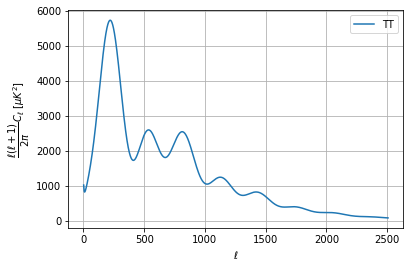

In [ ]:
input_cl.plot(y='TT', grid=True)
plt.ylabel("$\dfrac{\ell(\ell+1)}{2\pi} C_\ell~[\mu K^2]$")
plt.xlabel("$\ell$")

We can transform our data to get our values for $C_\ell$ which we'll use in healpy. Note that we also take into account that this plot is in $\mu$K squared.

In [ ]:
raw_cl = input_cl.divide(input_cl.index * (input_cl.index+1) / (2*np.pi),
                         axis='index') * 10**-12
raw_cl.head()

,TT,TE,EE,BB,PP
L,,,,,
2,1.064717e-09,2.741071e-12,3.234029e-14,1.904297e-18,5.250146e-20
3,5.046063e-10,1.538365e-12,2.078179e-14,1.904554e-18,3.193654e-20
4,2.867043e-10,8.666586e-13,1.083730e-14,1.904889e-18,2.207258e-20
5,1.831500e-10,4.925703e-13,4.836817e-15,1.905307e-18,1.639746e-20
6,1.269366e-10,2.836484e-13,1.937495e-15,1.905810e-18,1.276115e-20


We have no power spectrum values for $\ell = 0, 1$ so we can fill these in with zeroes.

In [ ]:
lmax = raw_cl.index[-1]  # get maximum multipole

raw_cl = raw_cl.reindex(np.arange(0, lmax+1))  # reindex
raw_cl = raw_cl.fillna(0)  # fill missing vals
raw_cl.head()

,TT,TE,EE,BB,PP
L,,,,,
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1.064717e-09,2.741071e-12,3.234029e-14,1.904297e-18,5.250146e-20
3,5.046063e-10,1.538365e-12,2.078179e-14,1.904554e-18,3.193654e-20
4,2.867043e-10,8.666586e-13,1.083730e-14,1.904889e-18,2.207258e-20


# **Generating CMB Maps**
We can now move onto generating our fake CMB maps using this power spectrum. Here we will be using healpy's synfast function to generate a map. Alternatively, we could use healpy to generate the $a_{lm}$'s and then use this to generate a map.

Here, we use $n_\textrm{side}=2048$ to generate a map with the same resolution as the string maps.

In [ ]:
map = hp.synfast(raw_cl.TT, nside=2048, lmax=lmax, new=True)

/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))



We can now plot the map using Mollview projection. To compare with the Planck map, we can specify the range.

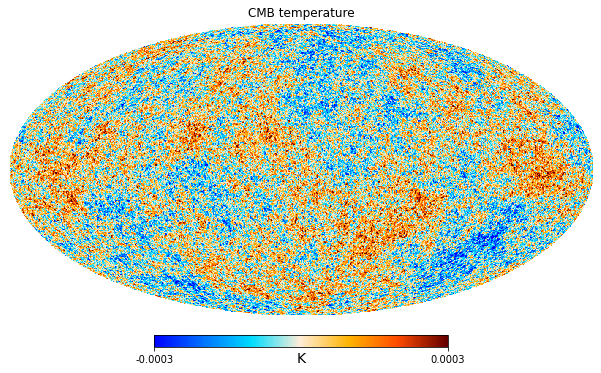

In [ ]:
hp.mollview(map, cmap=cmap, unit='K', title='CMB temperature',
            min=-300e-6, max=300e-6)

We can plot the spectrum of our map using healpy's anafast routine.

In [ ]:
map_cl = hp.anafast(map, lmax=lmax, use_pixel_weights=True) * 1e12
ell = np.arange(map_cl.size)
map_cl *= ell * (ell+1) / (2*np.pi)

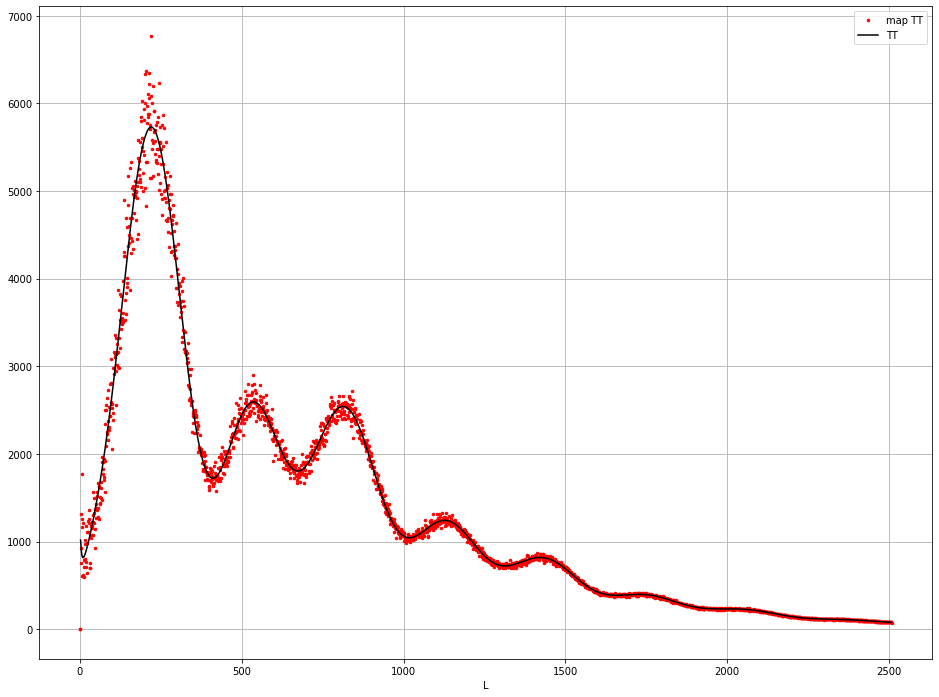

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(map_cl, label='map TT', marker='.', markersize=5, linestyle='None',
         color='red')
input_cl.TT.plot(grid=True, color='black')
plt.legend()


# **Partial plotting**
We can plot small sections of our CMB map using gnomonic view. To do this, we will use the healpy's gnomview routine.

First we will experiment with projecting our map using default arguments.

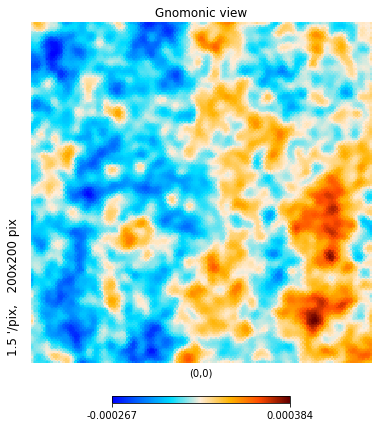

In [ ]:
hp.visufunc.gnomview(map, cmap=cmap)

Note that this does not plot the whole map, but only a small region. The resolution is (by default) 1.5 arcmin and the image dimensions are 200x200. So this is a 5 degree squared cutout taken from latitude=0, longitude=0.

We can write a function to extract specific regions of specific sizes. For example, if we want a 10 degree squared patch to correspond to an image size 200 x 200, we need a resolution of 3 arcmin.

Recall: $1' = \frac{1}{60}^{\circ}$

Then for an image with a side of $n$ degrees and a side of $N$ pixels:

$\textrm{resolution} = 60\frac{n}{N}' $

In [ ]:
def extract_map(map, rot, deg_side, pixel_side, cmap='jet'):
  '''
  rot must be a tuple (lon, lat, psi) where lon, lat specify where the
  centre of the extracted map will be and psi specifies a rotation.
  All of these are in units of degrees.
  '''
  reso = 60*deg_side/pixel_side
  mini_map = hp.visufunc.gnomview(map, rot=rot, xsize=pixel_side,
                                  reso=reso, return_projected_map=True,
                                  no_plot=False, cmap=cmap)
  return reso, mini_map

We can then use this to extract, for example, a 200x200 sized image for a 10 degree squared patch centred on lon=30, lat = -30.

In [ ]:
reso, mini_map = extract_map(map, (30, -30, 0), 10, 200, cmap=cmap)

TypeError: ignored

The array will be stored in the mini_map variable.

In [ ]:
print(mini_map.shape)
print(mini_map)

(200, 200)
[[ 1.59041618e-04  1.79165573e-04  1.98647049e-04 ...  6.22476939e-05
   7.38765870e-05  8.92811312e-05]
 [ 1.33722735e-04  1.79637526e-04  2.28801242e-04 ...  1.14627910e-04
   1.39040848e-04  1.12074327e-04]
 [ 1.05178249e-04  1.70035623e-04  2.12508243e-04 ...  1.62872786e-04
   1.70510407e-04  1.28990501e-04]
 ...
 [ 6.57241587e-05  3.83814951e-05  1.92339837e-05 ...  7.84316892e-05
   6.83527981e-05  4.80168803e-05]
 [ 3.44495166e-05  2.87404001e-06 -1.13840044e-05 ... -1.78634916e-05
   2.18661984e-05  1.97232190e-05]
 [ 2.73977468e-05 -1.83943361e-05 -2.96510106e-05 ... -5.18969825e-06
   1.79177562e-05  1.96592159e-05]]


# **Saving maps**
In this section, we will generate maps from healpy and save these to .fits files. We can then use these files later to extract smaller sized maps and combine these with the string cosmic maps.

In [ ]:
def extract_map(map, rot, deg_side, pixel_side):
  '''
  rot must be a tuple (lon, lat, psi) where lon, lat specify where the
  centre of the extracted map will be and psi specifies a rotation.
  All of these are in units of degrees.
  '''
  reso = 60*deg_side/pixel_side
  mini_map = hp.visufunc.gnomview(map, rot=rot, xsize=pixel_side,
                                  reso=reso, return_projected_map=True,
                                  no_plot=True)
  return mini_map

In [ ]:
num_maps = 250  # number of maps to generate
num_mini_maps = 20
deg_side = 5
pixel_side = 200

for n in range(num_maps):
  map = hp.synfast(raw_cl.TT, nside=2048, lmax=lmax)

  lon_list = np.random.randint(0, 360, size=num_mini_maps)
  lat_list = np.random.randint(-90, 90, size=num_mini_maps)
  
  mini_maps_new = [None]*num_mini_maps

  for i in range(num_mini_maps):
    mini_maps_new[i] = extract_map(map,
                              (lon_list[i], lat_list[i], 0),
                              deg_side, pixel_side)
  if n==0:
    mini_maps = mini_maps_new
  else:
    mini_maps = np.append(mini_maps, mini_maps_new, axis=0)

  print(f'Finished map {n+1}')

/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


Finished map 1
Finished map 2
Finished map 3
Finished map 4
Finished map 5
Finished map 6
Finished map 7
Finished map 8
Finished map 9
Finished map 10
Finished map 11
Finished map 12
Finished map 13
Finished map 14
Finished map 15
Finished map 16
Finished map 17
Finished map 18
Finished map 19
Finished map 20
Finished map 21
Finished map 22
Finished map 23
Finished map 24
Finished map 25
Finished map 26
Finished map 27
Finished map 28
Finished map 29
Finished map 30
Finished map 31
Finished map 32
Finished map 33
Finished map 34
Finished map 35
Finished map 36
Finished map 37
Finished map 38
Finished map 39
Finished map 40
Finished map 41
Finished map 42
Finished map 43
Finished map 44
Finished map 45
Finished map 46
Finished map 47
Finished map 48
Finished map 49
Finished map 50
Finished map 51
Finished map 52
Finished map 53
Finished map 54
Finished map 55
Finished map 56
Finished map 57
Finished map 58
Finished map 59
Finished map 60
Finished map 61
Finished map 62
Finished map 63
F

In [ ]:
mini_maps = np.array(mini_maps)
mini_maps.shape

(5000, 200, 200)

In [ ]:
np.save('cmb_5000_extracts_highres.npy', mini_maps)